Clearing memory

In [7]:
%reset -f
import gc
gc.collect()

0

## Importing libraries and custom functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import random
from torchmetrics.functional import mean_squared_error as mse
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image import StructuralSimilarityIndexMeasure

from scripts.noise import NoisyCIFAR10
from scripts.classic_filters import median_filter, gaussian_filter, lowpass_filter, highpass_filter
from scripts.models import ModelUtilsMixin
from scripts.model_utils import EarlyStopping, training_loop
from scripts.visualizing import plot_samples_from_dataloader, plot_denoising_examples, plot_learning_curves

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data loading, preparation and splitting

In [10]:
# Image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Loading CIFAR-10 dataset and splitting it into train, val и test sets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8*len(train_set))
val_size = int(0.2*len(train_set))
train_set, val_set = random_split(train_set, lengths=[train_size, val_size])

# Creating noisy datasets
train_dataset = NoisyCIFAR10(train_set)
val_dataset = NoisyCIFAR10(val_set)
test_dataset = NoisyCIFAR10(test_set)

# Turning noisy datasets into DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

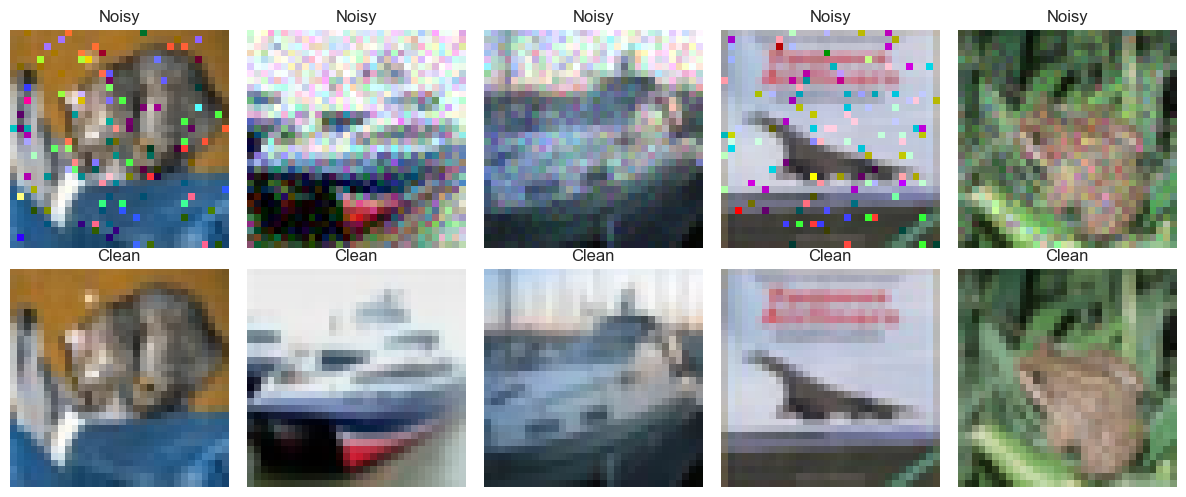

In [42]:
plot_samples_from_dataloader(test_loader)

## Classic filters

Checking classic filters working properly (no dimensionality issues)

In [12]:
# Example batch from DataLoader
images, _ = next(iter(train_loader)) # Extract a batch
print("Shape before filtering:", images.shape)  # [64, 3, 32, 32]

# Apply median filtering
filtered_images = median_filter(images)
print("Shape after filtering:", filtered_images.shape)  # [64, 3, 32, 32]

Shape before filtering: torch.Size([64, 3, 32, 32])
Shape after filtering: torch.Size([64, 3, 32, 32])


In [13]:
# Example batch from DataLoader
images, _ = next(iter(train_loader))  # Extract a batch
print("Shape before filtering:", images.shape)  # [64, 3, 32, 32]

# Apply Gaussian filtering
filtered_images = gaussian_filter(images)
print("Shape after filtering:", filtered_images.shape)  # [64, 3, 32, 32]

Shape before filtering: torch.Size([64, 3, 32, 32])
Shape after filtering: torch.Size([64, 3, 32, 32])


In [15]:
# Example batch from DataLoader
images, _ = next(iter(train_loader))  # Extract a batch
print("Shape before filtering:", images.shape)  # [64, 3, 32, 32]

# Apply lowpass filtering
filtered_images = lowpass_filter(batch=images)
print("Shape after filtering:", filtered_images.shape)  # [64, 3, 32, 32]


Shape before filtering: torch.Size([64, 3, 32, 32])
Shape after filtering: torch.Size([64, 3, 32, 32])


In [16]:
# Example batch from DataLoader
images, _ = next(iter(train_loader)) # Extract a batch
print("Shape before filtering:", images.shape)  # [64, 3, 32, 32]

# Apply highpass filtering
filtered_images = highpass_filter(batch=images)
print("Shape after filtering:", filtered_images.shape)  # [64, 3, 32, 32]

Shape before filtering: torch.Size([64, 3, 32, 32])
Shape after filtering: torch.Size([64, 3, 32, 32])


##  Simple CNN

In [52]:
class SimpleCNN(ModelUtilsMixin, nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=(64, 128)):
        super().__init__()
        self.layer1 = self._block(in_channels, features[0])
        self.layer2 = self._block(features[0], features[1])
        self.layer3 = self._block(features[1], features[1] * 2)
        self.layer4 = self._block(features[1] * 2, features[1])
        self.layer5 = self._block(features[1], features[0])
        self.layer6 =  self._block(features[0], out_channels)

    def forward(self, x):
        x = self.layer1(x)  # [B, 64, 32, 32]
        x = self.layer2(x)  # [B, 128, 32, 32]
        x = self.layer3(x)  # [B, 256, 32, 32]
        x = self.layer4(x)  # [B, 128, 32, 32]
        x = self.layer5(x)  # [B, 64, 32, 32]
        return self.layer6(x)  # [B, 3, 32, 32]

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

In [53]:
model = SimpleCNN().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
num_epochs = 50
early_stopper = EarlyStopping(patience=5, min_delta=0.0001)

In [54]:
train_loss, val_loss, _ = training_loop(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    loss_fn=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_every_n_epochs=10,
    early_stopping=early_stopper,
    device=device
)

  2%|▏         | 1/50 [00:13<10:44, 13.15s/it]

Epoch: 1  | Train loss: 0.0092 | Test loss: 0.0029 | 

 20%|██        | 10/50 [02:43<10:55, 16.38s/it]

Epoch: 11 | Train loss: 0.0014 | Test loss: 0.0012 | Early stopping triggered at epoch 11


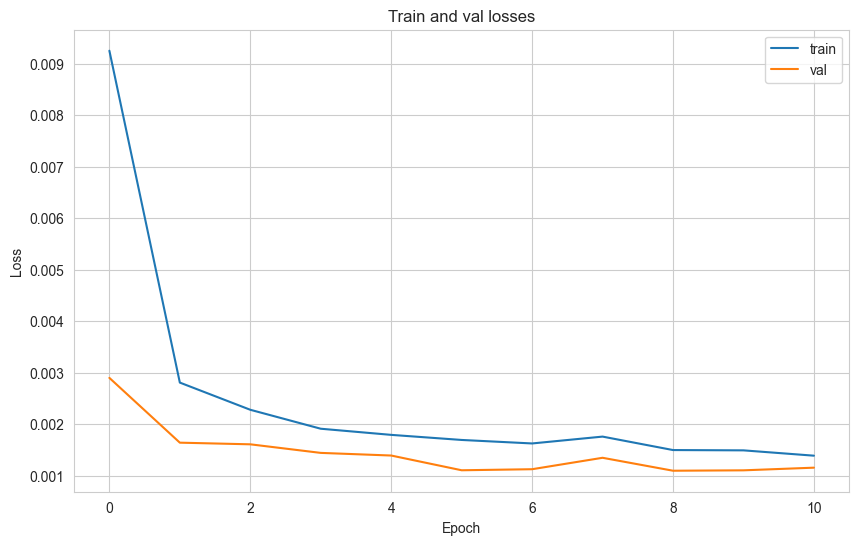

In [55]:
plot_learning_curves(train_loss, val_loss)

## U-Net

In [75]:
class UNet(ModelUtilsMixin, nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=(64, 128)):
        super().__init__()

        # Encoder
        self.encoder1 = self._block(in_channels, features[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = self._block(features[0], features[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self._block(features[1], features[1] * 2)

        # Decoder
        self.upconv2 = nn.ConvTranspose2d(features[1] * 2, features[1], kernel_size=2, stride=2)
        self.decoder2 = self._block(features[1] * 2, features[1])

        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.decoder1 = self._block(features[0] * 2, features[0])

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)  # [B, 64, 32, 32]
        enc2 = self.encoder2(self.pool1(enc1))  # [B, 128, 16, 16]
        bottleneck = self.bottleneck(self.pool2(enc2))  # [B, 256, 8, 8]

        dec2 = self.upconv2(bottleneck)  # [B, 128, 16, 16]
        dec2 = torch.cat((dec2, enc2), dim=1)  # [B, 256, 16, 16]
        dec2 = self.decoder2(dec2)  # [B, 128, 16, 16]

        dec1 = self.upconv1(dec2)  # [B, 64, 32, 32]
        dec1 = torch.cat((dec1, enc1), dim=1)  # [B, 128, 32, 32]
        dec1 = self.decoder1(dec1)  # [B, 64, 32, 32]

        return self.final_conv(dec1)  # [B, 3, 32, 32]

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

In [57]:
model = UNet().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
num_epochs = 50
early_stopper = EarlyStopping(patience=5, min_delta=0.0001)

In [58]:
train_loss, val_loss, _ = training_loop(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    loss_fn=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_every_n_epochs=1,
    early_stopping=early_stopper,
    device=device
)

  2%|▏         | 1/50 [00:10<08:40, 10.62s/it]

Epoch: 1  | Train loss: 0.008  | Test loss: 0.002  | 

  4%|▍         | 2/50 [00:20<08:06, 10.13s/it]

Epoch: 2  | Train loss: 0.0022 | Test loss: 0.0015 | 

  6%|▌         | 3/50 [00:30<07:55, 10.12s/it]

Epoch: 3  | Train loss: 0.002  | Test loss: 0.0014 | 

  8%|▊         | 4/50 [00:41<07:54, 10.31s/it]

Epoch: 4  | Train loss: 0.0018 | Test loss: 0.0015 | 

 10%|█         | 5/50 [00:51<07:42, 10.29s/it]

Epoch: 5  | Train loss: 0.0017 | Test loss: 0.0012 | 

 12%|█▏        | 6/50 [01:01<07:27, 10.17s/it]

Epoch: 6  | Train loss: 0.0016 | Test loss: 0.0016 | 

 14%|█▍        | 7/50 [01:11<07:13, 10.08s/it]

Epoch: 7  | Train loss: 0.0015 | Test loss: 0.0011 | 

 16%|█▌        | 8/50 [01:21<07:05, 10.13s/it]

Epoch: 8  | Train loss: 0.0014 | Test loss: 0.0012 | 

 18%|█▊        | 9/50 [01:31<06:54, 10.10s/it]

Epoch: 9  | Train loss: 0.0014 | Test loss: 0.001  | 

 20%|██        | 10/50 [01:50<08:39, 12.99s/it]

Epoch: 10 | Train loss: 0.0014 | Test loss: 0.0011 | 

 22%|██▏       | 11/50 [02:07<09:13, 14.20s/it]

Epoch: 11 | Train loss: 0.0013 | Test loss: 0.0012 | 

 24%|██▍       | 12/50 [02:17<08:11, 12.93s/it]

Epoch: 12 | Train loss: 0.0013 | Test loss: 0.0011 | 

 26%|██▌       | 13/50 [02:27<07:21, 11.94s/it]

Epoch: 13 | Train loss: 0.0012 | Test loss: 0.0009 | 

 28%|██▊       | 14/50 [02:44<08:03, 13.43s/it]

Epoch: 14 | Train loss: 0.0012 | Test loss: 0.0009 | 

 30%|███       | 15/50 [03:01<08:29, 14.56s/it]

Epoch: 15 | Train loss: 0.0011 | Test loss: 0.0009 | 

 32%|███▏      | 16/50 [03:11<07:27, 13.17s/it]

Epoch: 16 | Train loss: 0.0011 | Test loss: 0.0009 | 

 34%|███▍      | 17/50 [03:26<07:34, 13.77s/it]

Epoch: 17 | Train loss: 0.0011 | Test loss: 0.0008 | 

 36%|███▌      | 18/50 [03:41<07:29, 14.05s/it]

Epoch: 18 | Train loss: 0.0011 | Test loss: 0.0009 | 

 36%|███▌      | 18/50 [03:51<06:51, 12.87s/it]

Epoch: 19 | Train loss: 0.0011 | Test loss: 0.001  | Early stopping triggered at epoch 19


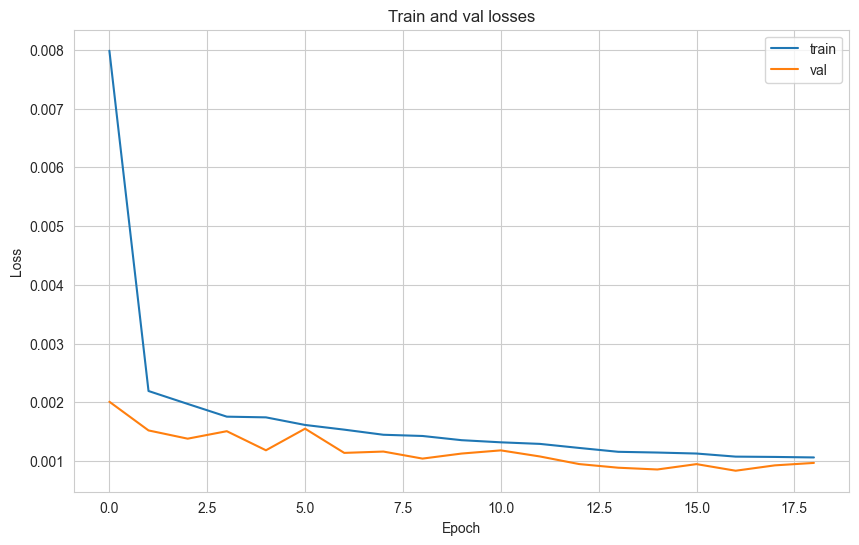

In [59]:
plot_learning_curves(train_loss, val_loss)

## Autoencoder

In [99]:
class Autoencoder(ModelUtilsMixin, nn.Module):
    def __init__(self, input_channels=3, latent_dim=128, features=(64, 128)):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, features[0], kernel_size=3, stride=2, padding=1),  # [B, 64, H/2, W/2]
            nn.ReLU(),
            nn.Conv2d(features[0], features[1], kernel_size=3, stride=2, padding=1),  # [B, 128, H/4, W/4]
            nn.ReLU(),
            nn.Conv2d(features[1], features[1] * 2, kernel_size=3, stride=2, padding=1),  # [B, 256, H/8, W/8]
            nn.ReLU(),
            nn.Flatten(),  # Flatten for latent representation
            nn.Linear(features[1] * 2 * (4 * 4), latent_dim),  # Reduce to latent space
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, features[1] * 2 * (4 * 4)),  # Expand latent space
            nn.Unflatten(1, (features[1] * 2, 4, 4)),  # Reshape for ConvTranspose2d
            nn.ConvTranspose2d(features[1] * 2, features[1], kernel_size=2, stride=2),  # [B, 128, H/4, W/4]
            nn.ReLU(),
            nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2),  # [B, 64, H/2, W/2]
            nn.ReLU(),
            nn.ConvTranspose2d(features[0], input_channels, kernel_size=2, stride=2),  # [B, input_channels, H, W]
            nn.Sigmoid(),  # Normalize output to [0, 1]
        )

    def forward(self, x):
        # Forward pass through encoder
        latent = self.encoder(x)
        # Forward pass through decoder
        reconstructed = self.decoder(latent)
        return reconstructed

In [100]:
model = Autoencoder().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
num_epochs = 50
early_stopper = EarlyStopping(patience=5, min_delta=0.0001)

In [101]:
train_loss, val_loss, _ = training_loop(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    loss_fn=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_every_n_epochs=1,
    early_stopping=early_stopper,
    device=device
)

  2%|▏         | 1/50 [00:07<06:20,  7.76s/it]

Epoch: 1  | Train loss: 0.0164 | Test loss: 0.0097 | 

  4%|▍         | 2/50 [00:15<06:10,  7.72s/it]

Epoch: 2  | Train loss: 0.0081 | Test loss: 0.0068 | 

  6%|▌         | 3/50 [00:23<06:02,  7.71s/it]

Epoch: 3  | Train loss: 0.0063 | Test loss: 0.0059 | 

  8%|▊         | 4/50 [00:30<05:53,  7.69s/it]

Epoch: 4  | Train loss: 0.0056 | Test loss: 0.0054 | 

 10%|█         | 5/50 [00:38<05:43,  7.62s/it]

Epoch: 5  | Train loss: 0.0053 | Test loss: 0.0052 | 

 12%|█▏        | 6/50 [00:46<05:36,  7.65s/it]

Epoch: 6  | Train loss: 0.0052 | Test loss: 0.0052 | 

 14%|█▍        | 7/50 [00:53<05:28,  7.65s/it]

Epoch: 7  | Train loss: 0.0051 | Test loss: 0.0051 | 

 16%|█▌        | 8/50 [01:01<05:18,  7.59s/it]

Epoch: 8  | Train loss: 0.0051 | Test loss: 0.0051 | 

 18%|█▊        | 9/50 [01:08<05:12,  7.61s/it]

Epoch: 9  | Train loss: 0.005  | Test loss: 0.005  | 

 20%|██        | 10/50 [01:16<05:08,  7.71s/it]

Epoch: 10 | Train loss: 0.005  | Test loss: 0.0051 | 

 22%|██▏       | 11/50 [01:24<04:57,  7.64s/it]

Epoch: 11 | Train loss: 0.0049 | Test loss: 0.005  | 

 24%|██▍       | 12/50 [01:31<04:46,  7.53s/it]

Epoch: 12 | Train loss: 0.0049 | Test loss: 0.005  | 

 26%|██▌       | 13/50 [01:39<04:38,  7.54s/it]

Epoch: 13 | Train loss: 0.0048 | Test loss: 0.0049 | 

 28%|██▊       | 14/50 [01:46<04:28,  7.46s/it]

Epoch: 14 | Train loss: 0.0048 | Test loss: 0.0049 | 

 30%|███       | 15/50 [01:53<04:23,  7.52s/it]

Epoch: 15 | Train loss: 0.0048 | Test loss: 0.0049 | 

 32%|███▏      | 16/50 [02:01<04:15,  7.50s/it]

Epoch: 16 | Train loss: 0.0048 | Test loss: 0.0049 | 

 34%|███▍      | 17/50 [02:14<05:03,  9.19s/it]

Epoch: 17 | Train loss: 0.0048 | Test loss: 0.0049 | 

 36%|███▌      | 18/50 [02:28<05:44, 10.76s/it]

Epoch: 18 | Train loss: 0.0047 | Test loss: 0.0049 | 

 36%|███▌      | 18/50 [02:36<04:38,  8.70s/it]

Epoch: 19 | Train loss: 0.0047 | Test loss: 0.0049 | Early stopping triggered at epoch 19


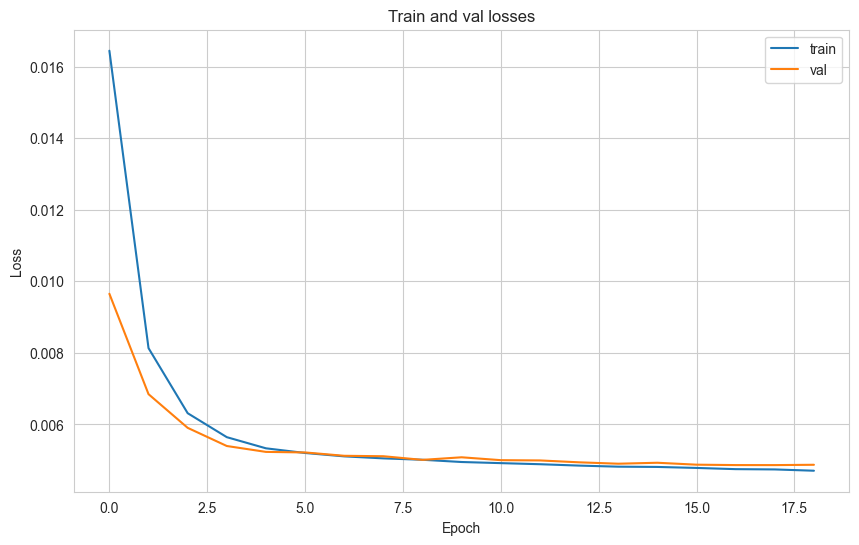

In [102]:
plot_learning_curves(train_loss, val_loss)

## Testing classic filters and models

### First batch for plotting

Loading models

In [91]:
cnn_model = SimpleCNN().to(device)
cnn_model.load_state_dict(torch.load('./models/SimpleCNN_best.pth'))

<All keys matched successfully>

In [92]:
unet_model = UNet().to(device)
unet_model.load_state_dict(torch.load('./models/UNet_best.pth'))

<All keys matched successfully>

In [93]:
autoenc_model = Autoencoder().to(device)
autoenc_model.load_state_dict(torch.load('./models/Autoencoder_best.pth'))

<All keys matched successfully>

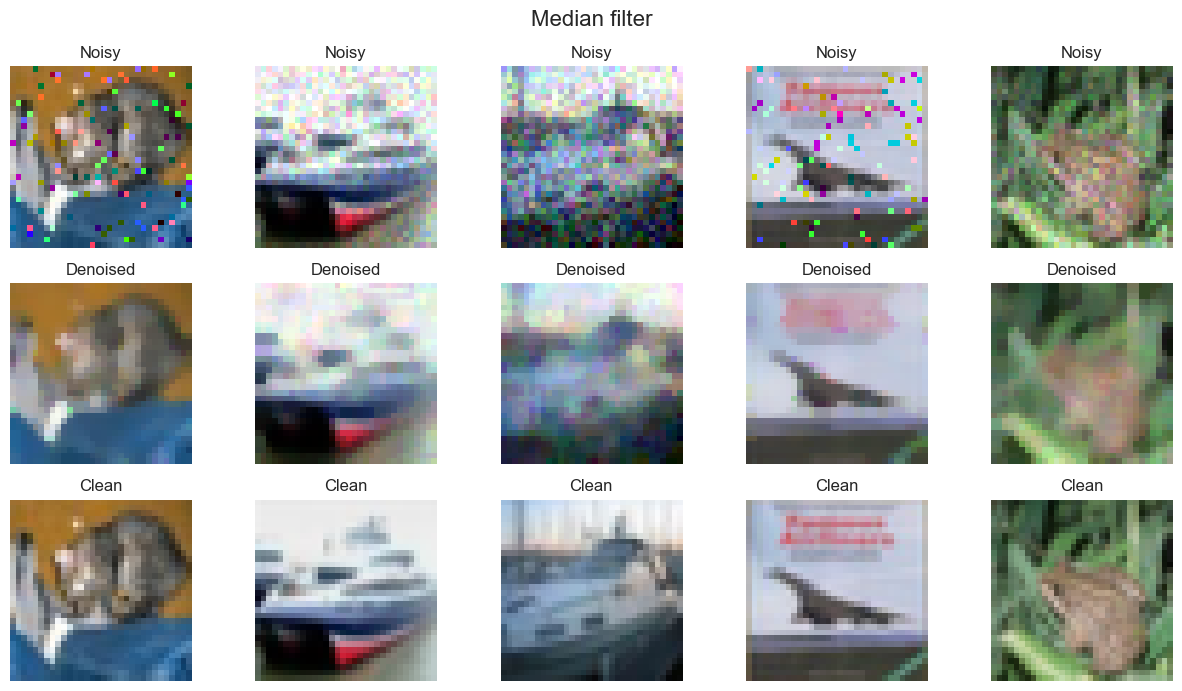

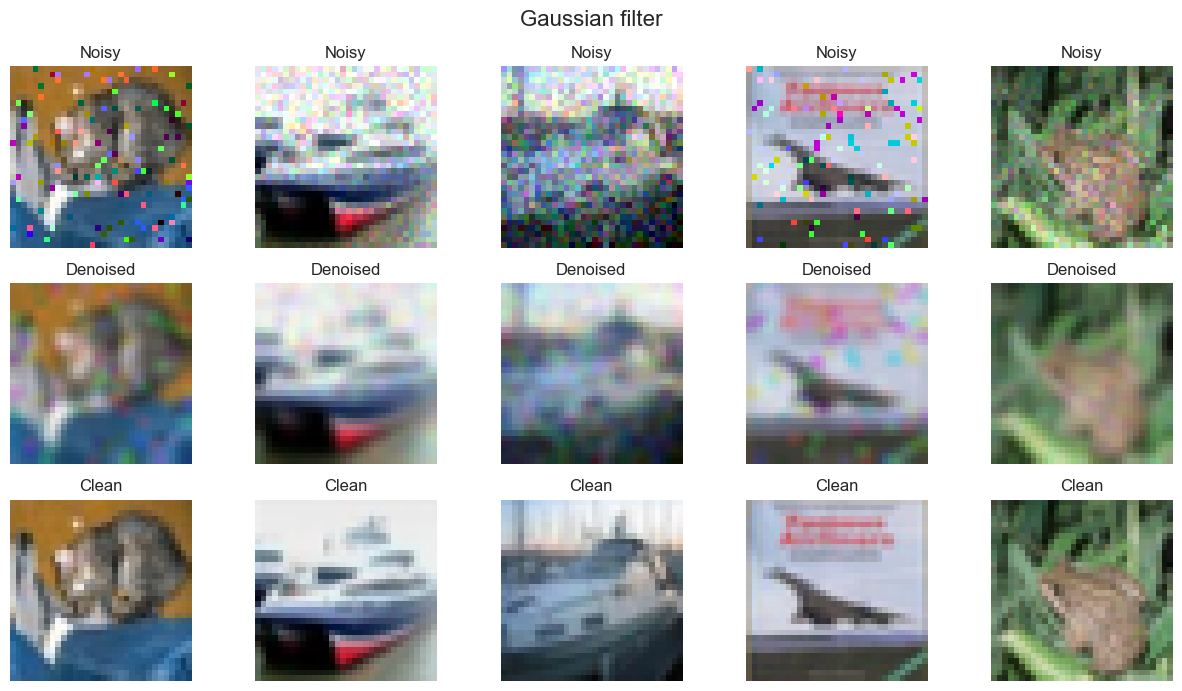

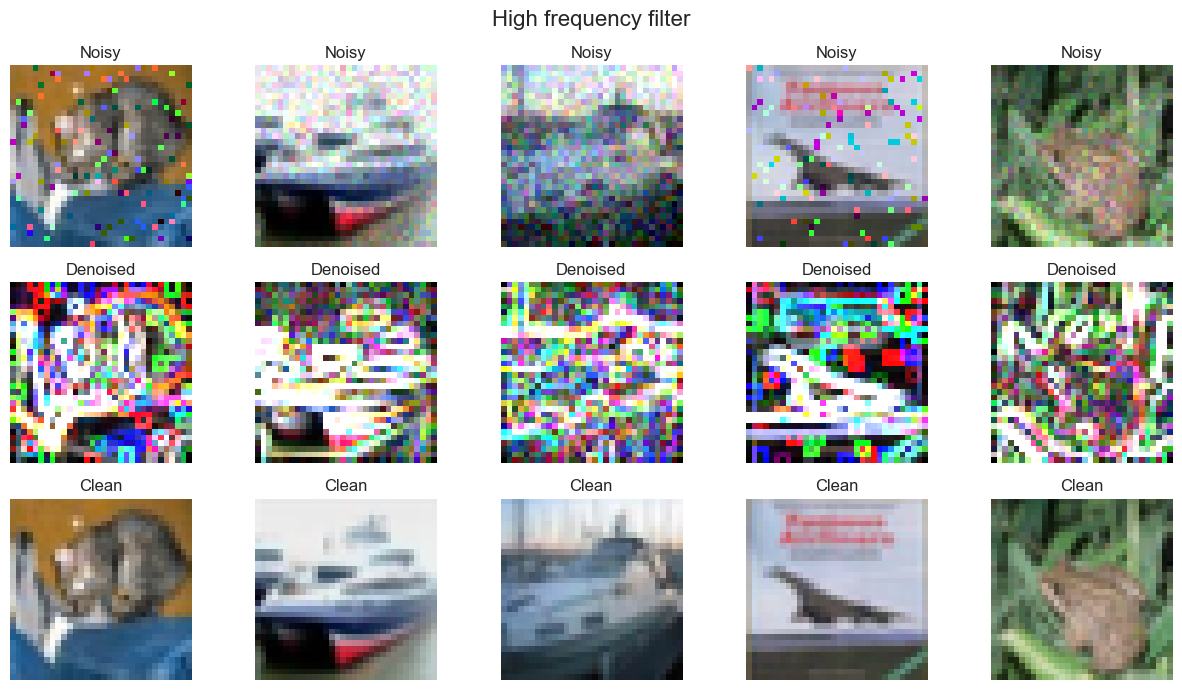

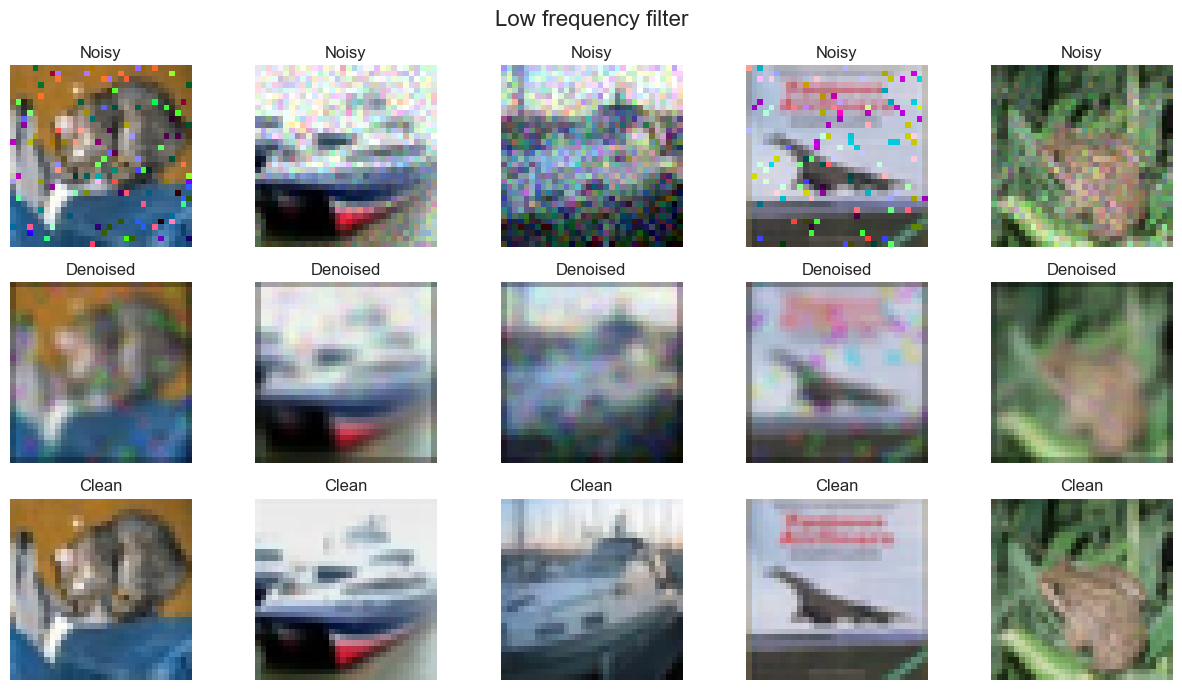

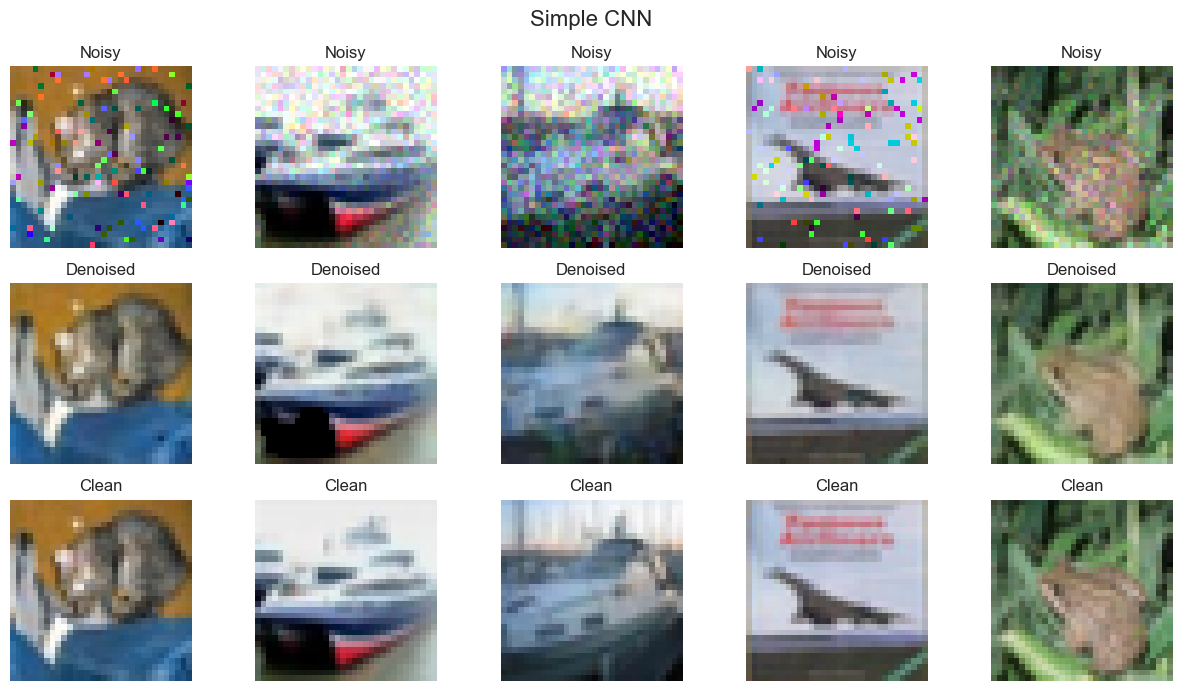

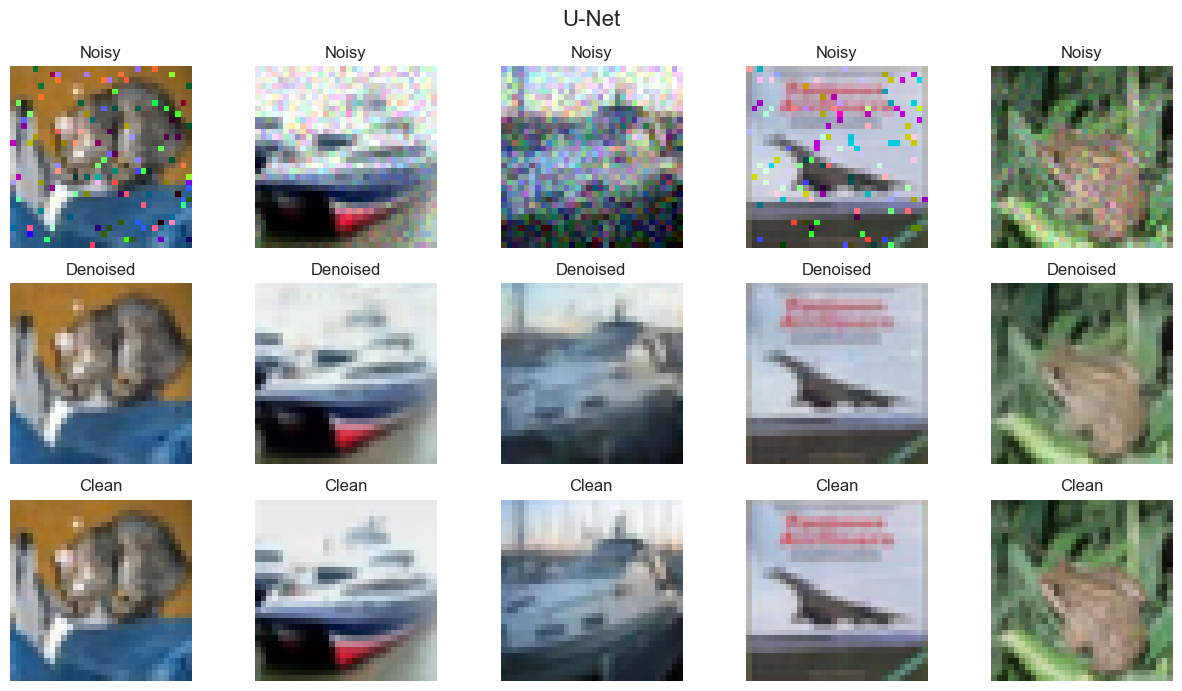

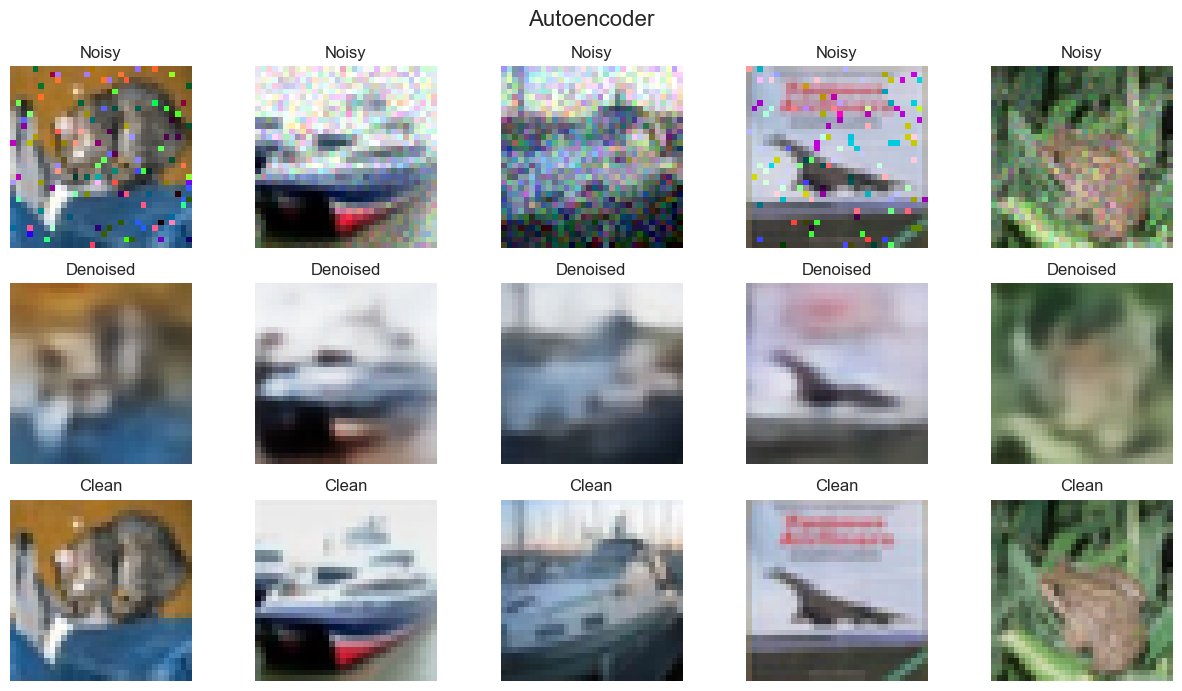

In [94]:
cnn_model.eval()
unet_model.eval()
autoenc_model.eval()

with torch.inference_mode():
    for noisy_imgs, clean_imgs in test_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        # Median filter
        denoised_imgs = median_filter(noisy_imgs)
        plot_denoising_examples(noisy_imgs, clean_imgs, denoised_imgs, title='Median filter')

        # Gaussian filter
        denoised_imgs = gaussian_filter(noisy_imgs)
        plot_denoising_examples(noisy_imgs, clean_imgs, denoised_imgs, title='Gaussian filter')

        # High frequency filter
        denoised_imgs = highpass_filter(noisy_imgs)
        plot_denoising_examples(noisy_imgs, clean_imgs, denoised_imgs, title='High frequency filter')

        # Low frequency filter
        denoised_imgs = lowpass_filter(noisy_imgs)
        plot_denoising_examples(noisy_imgs, clean_imgs, denoised_imgs, title='Low frequency filter')

        # Simple CNN model
        denoised_imgs = cnn_model(noisy_imgs)
        plot_denoising_examples(noisy_imgs, clean_imgs, denoised_imgs, title='Simple CNN')

        # U-Net model
        denoised_imgs = unet_model(noisy_imgs)
        plot_denoising_examples(noisy_imgs, clean_imgs, denoised_imgs, title='U-Net')

        # Autoencoder
        denoised_imgs = autoenc_model(noisy_imgs)
        plot_denoising_examples(noisy_imgs, clean_imgs, denoised_imgs, title='Autoencoder')
        break

### Comparing models

Loading models

In [95]:
cnn_model = SimpleCNN().to(device)
cnn_model.load_state_dict(torch.load('./models/SimpleCNN_best.pth'))

<All keys matched successfully>

In [96]:
unet_model = UNet().to(device)
unet_model.load_state_dict(torch.load('./models/UNet_best.pth'))

<All keys matched successfully>

In [97]:
autoenc_model = Autoencoder().to(device)
autoenc_model.load_state_dict(torch.load('./models/Autoencoder_best.pth'))

<All keys matched successfully>

#### Metrics

For performance evaluation and comparing with other models were used 3 metrics: MSE, PSNR, SSIM

In [103]:
metrics = {model_name: {'MSE': 0, 'PSNR': 0, 'SSIM': 0} for model_name in ['median', 'gauss', 'high', 'low', 'cnn', 'unet', 'auto']}
total_batches = len(test_loader)

psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

cnn_model.eval()
unet_model.eval()
autoenc_model.eval()

with torch.inference_mode():
    for noisy_imgs, clean_imgs in test_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        # Median filter
        denoised_imgs = median_filter(noisy_imgs)
        mse_median = mse(denoised_imgs, clean_imgs)
        psnr_median = psnr(denoised_imgs, clean_imgs)
        ssim_median = ssim(denoised_imgs, clean_imgs)

        metrics['median']['MSE'] += mse_median.item()
        metrics['median']['PSNR'] += psnr_median.item()
        metrics['median']['SSIM'] += ssim_median.item()

        # Gaussian filter
        denoised_imgs = gaussian_filter(noisy_imgs)
        mse_gauss = mse(denoised_imgs, clean_imgs)
        psnr_gauss = psnr(denoised_imgs, clean_imgs)
        ssim_gauss = ssim(denoised_imgs, clean_imgs)

        metrics['gauss']['MSE'] += mse_gauss.item()
        metrics['gauss']['PSNR'] += psnr_gauss.item()
        metrics['gauss']['SSIM'] += ssim_gauss.item()

        # High frequency filter
        denoised_imgs = highpass_filter(noisy_imgs)
        mse_high = mse(denoised_imgs, clean_imgs)
        psnr_high = psnr(denoised_imgs, clean_imgs)
        ssim_high = ssim(denoised_imgs, clean_imgs)

        metrics['high']['MSE'] += mse_high.item()
        metrics['high']['PSNR'] += psnr_high.item()
        metrics['high']['SSIM'] += ssim_high.item()

        # Low frequency filter
        denoised_imgs = lowpass_filter(noisy_imgs)
        mse_low = mse(denoised_imgs, clean_imgs)
        psnr_low = psnr(denoised_imgs, clean_imgs)
        ssim_low = ssim(denoised_imgs, clean_imgs)

        metrics['low']['MSE'] += mse_low.item()
        metrics['low']['PSNR'] += psnr_low.item()
        metrics['low']['SSIM'] += ssim_low.item()

        # Simple CNN model
        denoised_imgs = cnn_model(noisy_imgs)
        mse_cnn = mse(denoised_imgs, clean_imgs)
        psnr_cnn = psnr(denoised_imgs, clean_imgs)
        ssim_cnn = ssim(denoised_imgs, clean_imgs)

        metrics['cnn']['MSE'] += mse_cnn.item()
        metrics['cnn']['PSNR'] += psnr_cnn.item()
        metrics['cnn']['SSIM'] += ssim_cnn.item()

        # U-Net model
        denoised_imgs = unet_model(noisy_imgs)
        mse_unet = mse(denoised_imgs, clean_imgs)
        psnr_unet = psnr(denoised_imgs, clean_imgs)
        ssim_unet = ssim(denoised_imgs, clean_imgs)

        metrics['unet']['MSE'] += mse_unet.item()
        metrics['unet']['PSNR'] += psnr_unet.item()
        metrics['unet']['SSIM'] += ssim_unet.item()

        # Autoencoder
        denoised_imgs = autoenc_model(noisy_imgs)
        mse_auto = mse(denoised_imgs, clean_imgs)
        psnr_auto = psnr(denoised_imgs, clean_imgs)
        ssim_auto = ssim(denoised_imgs, clean_imgs)

        metrics['auto']['MSE'] += mse_auto.item()
        metrics['auto']['PSNR'] += psnr_auto.item()
        metrics['auto']['SSIM'] += ssim_auto.item()



for model_name in metrics.keys():
    metrics[model_name]['MSE'] /= total_batches
    metrics[model_name]['PSNR'] /= total_batches
    metrics[model_name]['SSIM'] /= total_batches


metrics_df = pd.DataFrame(metrics)

metrics_df

,median,gauss,high,low,cnn,unet,auto
MSE,0.003657,0.003447,0.399628,0.007390,0.001100,0.000849,0.004870
PSNR,24.379194,24.631917,3.992445,21.321027,29.598563,30.728583,23.132721
SSIM,0.794412,0.800036,0.005123,0.695280,0.920759,0.936856,0.750056


The U-Net model showed the best results, reaching PSNR = 30.73 and SIM = 0.94, which indicates high recovery accuracy and excellent visual quality. The usual convolutional neural network also showed almost the same result.

It is worth noting that median and Gaussian filtering showed acceptable results (even better than autoencoder). The spatial low-pass filter showed the worst working result, the high-pass filter did not cope with the task.